In [1]:
import numpy as np
import math
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import progressbar
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

In [2]:
bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

In [3]:
def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

In [4]:
class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed

    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

In [ ]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test


# Decision stump used as weak classifier in this impl. of Adaboost
class DecisionStump():
    def __init__(self):
        # Determines if sample shall be classified as -1 or 1 given threshold
        self.polarity = 1
        # The index of the feature used to make classification
        self.feature_index = None
        # The threshold value that the feature should be measured against
        self.threshold = None
        # Value indicative of the classifier's accuracy
        self.alpha = None

class Adaboost():
    """Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree. 
    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used. 
    """
    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            # Minimum error given for using a certain feature value threshold
            # for predicting sample label
            min_error = float('inf')
            # Iterate throught every unique feature value and see what value
            # makes the best threshold for predicting y
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # Try every unique feature value as threshold
                for threshold in unique_values:
                    p = 1
                    # Set all predictions to '1' initially
                    prediction = np.ones(np.shape(y))
                    # Label the samples whose values are below threshold as '-1'
                    prediction[X[:, feature_i] < threshold] = -1
                    # Error = sum of weights of misclassified samples
                    error = sum(w[y != prediction])
                    
                    # If the error is over 50% we flip the polarity so that samples that
                    # were classified as 0 are classified as 1, and vice versa
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # If this threshold resulted in the smallest error we save the
                    # configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Calculate new weights 
            # Missclassified samples gets larger weights and correctly classified samples smaller
            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y_pred))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf.alpha * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()

        return y_pred

In [12]:
with open("data_banknote_authentication.txt") as f:
    data = f.read().splitlines()

n = len(data)
X = np.zeros((n,4))
y = np.zeros(n)

for i, line in enumerate(data):
    parse_line = line.split(',')
    X[i,:], y[i] = parse_line[:4], parse_line[4]
    
X, y

(array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699],
        [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
        [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
        ...,
        [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
        [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
        [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ]]),
 array([0., 0., 0., ..., 1., 1., 1.]))

Accuracy: 0.9956268221574344


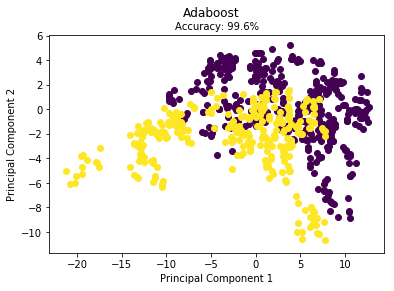

In [15]:
# Change labels to {-1, 1}
y -= (y == 0.)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Adaboost classification with 5 weak classifiers
clf = Adaboost(n_clf=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)

# Reduce dimensions to 2d using pca and plot the results
Plot().plot_in_2d(X_test, y_pred, title="Adaboost", accuracy=accuracy)